# Determine which pairs of mutated positions are linked, and plot results

**Part 2 of the "linked mutations" analyses.**

In [1]:
%run "Header.ipynb"

In [2]:
import pickle
import networkx as nx
from linked_mutations_utils import (
    MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE, emptyListOf4
)

## Using the computed groups...

### Plot $|Reads(i, j)|$ vs. $\big(|Reads(i, -)| + |Reads(-, j)|\big)$

Minor considerations, based on how this data was computed in the first linked mutations notebook:

- We have already excluded mutated positions with less than some min coverage (current value is 1,000x).
- We have already excluded pairs more than some distance away from each other (current value is 3 kbp).
  - (Note that we do allow for pairs to span the start/end of the genome.)
  
We could also subset these pairs to just "consecutive" ones; however, doing that while allowing for pairs to span the start/end of the genome is tricky, so for simplicity's sake we just show all (potentially) valid pairs here.

On seq edge_6104.
....................................................................................................
Done with edge_6104!

On seq edge_1671.
...................................................................................................
Done with edge_1671!

On seq edge_2358.
...................................................................................................
Done with edge_2358!


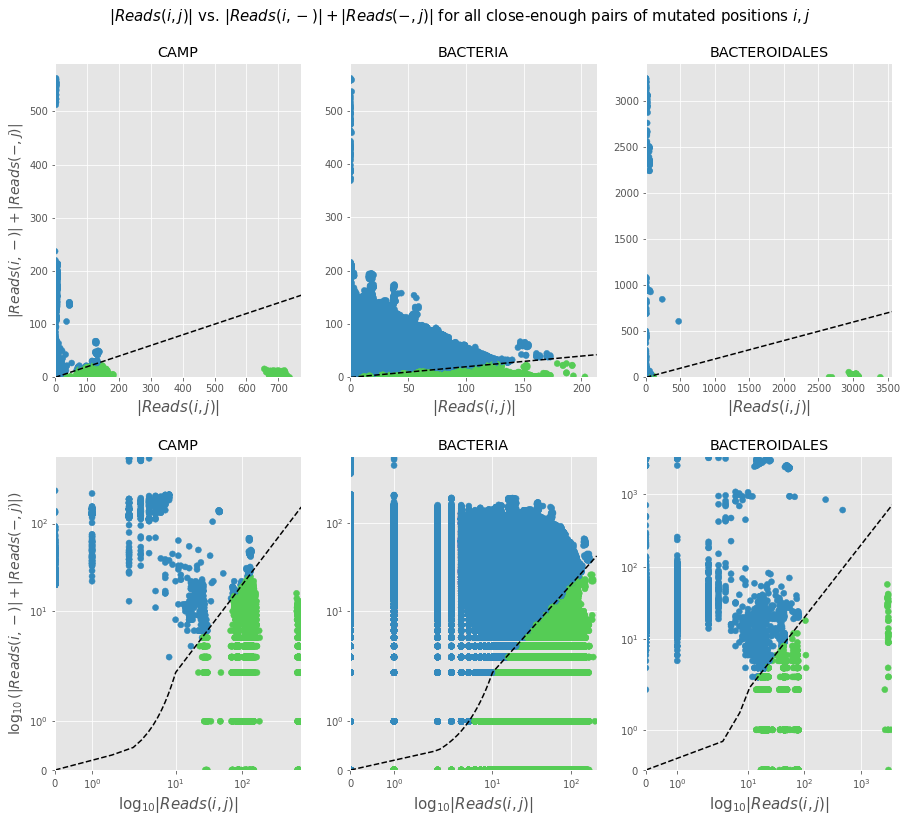

In [3]:
fig, axes = pyplot.subplots(2, 3, gridspec_kw={"hspace": 0.25})
for i, seq in enumerate(SEQS):
    print(f"On seq {seq}.")
    with open(f"pospair2groupcts/{seq}_pospair2groupcts.pickle", "rb") as pf:
        pospair2groupcts = pickle.load(pf)
    
    axNonLog = axes[0, i]
    axLog = axes[1, i]
    
    onehundredth = round(len(pospair2groupcts) / 100)
    plotx = []
    ploty = []
    plotcolor = []
    for ii, pospair in enumerate(sorted(pospair2groupcts.keys()), 1):
        
        # Crude progress bar.
        # This might occasionally print 99 or 101 dots instead of 100 dots per genome, but this is reasonable
        # enough. Just to reassure myself that this hasn't crashed my laptop.
        if ii % onehundredth == 0:
            print(".", end="")
            
        cts = pospair2groupcts[pospair]

        # Color pairs that are less than the 0.2 threshold specially (this is the remaining condition
        # for these pairs being linked, although we could also have non-consecutive mutations be linked
        # since the pairs we draw here are just a subset of the total pairs)
        if (cts[1] + cts[2]) < MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE * cts[0]:
            color = "#55cc55"
        else:
            color = SCATTERPLOT_PT_COLOR

        plotx.append(cts[0])
        ploty.append(cts[1] + cts[2])
        plotcolor.append(color)
            
    # Building up a list of x/y/color values, and then plotting that, is A TON faster than plotting each
    # point individually (like, calling ax.scatter() for each point). Hence why we do it here!
    # There are some other notebooks in this repo that do things the other way (e.g. as of writing the
    # "within-gene" plots plot each point individually) -- but those plots usually have at most a few thousand
    # points per plot, so it's not anywhere near as big a deal as it is here.
    axNonLog.scatter(plotx, ploty, c=plotcolor)
    axLog.scatter(plotx, ploty, c=plotcolor)
    print(f"\nDone with {seq}!")
    if i < 2:
        print("\n", end="")
    if i == 0:
        axNonLog.set_ylabel("$|Reads(i, -)| + |Reads(-, j)|$", fontsize=14)
        axLog.set_ylabel("$\log_{10} \, (|Reads(i, -)| + |Reads(-, j)|)$", fontsize=14)
        
    axNonLog.set_xlabel("$|Reads(i, j)|$", fontsize=15)
    axLog.set_xlabel("$\log_{10} |Reads(i, j)|$", fontsize=15)
        
    # Bound the left and bottom of each scatterplot at x = 0 and y = 0
    axNonLog.set_xlim(0)
    axNonLog.set_ylim(0)
    axLog.set_xlim(0)
    axLog.set_ylim(0)
    
    # Plot the line y = (MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE) * x
    # Represents the cutoff point for when or not we consider a pair of mutated positions to be linked.
    # Based on https://stackoverflow.com/a/43811762.
    xvals = axNonLog.get_xlim()
    yvals = [MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE * x for x in xvals]
    axNonLog.plot(xvals, yvals, "--", c="#000000")
    
    # Approximate the same line in the log plot. Just connect 
    maxx = max(axLog.get_xlim())
    dx = maxx / 1000
    lxvals = [dx * d for d in range(1001)]
    lyvals = [MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE * x for x in lxvals]
    axLog.plot(lxvals, lyvals, "--", c="#000000")
    
    axLog.set_xscale("symlog")
    axLog.set_yscale("symlog")
    
    axNonLog.set_title(seq2name[seq])
    axLog.set_title(seq2name[seq])
    
fig.suptitle(
    "$|Reads(i, j)|$ vs. $|Reads(i, -)| + |Reads(-, j)|$ for all close-enough pairs of mutated positions $i, j$",
    fontsize="15",
    y=0.94
)
fig.set_size_inches(15, 13)
fig.savefig("figs/readsij_scatterplots.png", bbox_inches="tight")

## Define mutated positions as "linked" or not, and then create a graph

__Nodes:__ Mutated positions.

__Edges:__ Connect _linked_ mutated positions.

In [4]:
for i, seq in enumerate(SEQS):
    g = nx.Graph()
    print(f"On seq {seq}...", end=" ")
    with open(f"pospair2groupcts/{seq}_pospair2groupcts.pickle", "rb") as pf:
        pospair2groupcts = pickle.load(pf)
        
    # Adding the same node twice doesn't hurt, so the lazy approach is ok
    # (not calling find_mutated_positions() from the utils file since that requires loading some big
    # JSONs into memory which will bork my laptop)
    for pair in pospair2groupcts:
        g.add_node(pair[0])
        g.add_node(pair[1])
        
        cts = pospair2groupcts[pair]
        if (cts[1] + cts[2]) < MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE * cts[0]:
            g.add_edge(*pair)
            
#         if pair[0] == 1209001 or pair[1] == 1209001:
#             print(pair, cts)
    
    nx.write_graphml(g, f"graphs/{seq}_linked_mutations.graphml")
    print("Wrote out graph!")

On seq edge_6104... Wrote out graph!
On seq edge_1671... Wrote out graph!
On seq edge_2358... Wrote out graph!


In [5]:
# Will probs delete, but: check out G1217!!!!
with open(f"pospair2groupcts/edge_6104_pospair2groupcts.pickle", "rb") as pf:
    pospair2groupcts = pickle.load(pf)

In [6]:
for pair in pospair2groupcts.keys():
    if 1209000 in pair:
        print(pair, pospair2groupcts[pair])

(1206907, 1209000) [3, 19, 543, 2988]
(1209000, 1209009) [699, 10, 3, 3735]
(1209000, 1209021) [707, 3, 3, 3753]
(1209000, 1209057) [707, 3, 3, 3745]
(1209000, 1209103) [700, 3, 4, 3728]
(1209000, 1209114) [693, 2, 3, 3722]
(1209000, 1209120) [700, 3, 3, 3721]
(1209000, 1209125) [700, 2, 3, 3719]
(1209000, 1209132) [698, 1, 3, 3716]
(1209000, 1209135) [703, 2, 5, 3711]
(1209000, 1209141) [703, 2, 3, 3711]
(1209000, 1209144) [701, 3, 4, 3709]
(1209000, 1209147) [700, 4, 3, 3706]
(1209000, 1209153) [700, 3, 4, 3705]
(1209000, 1209204) [697, 3, 3, 3678]
(1209000, 1209240) [701, 3, 5, 3670]
(1209000, 1209264) [699, 2, 3, 3669]
(1209000, 1209265) [696, 5, 3, 3671]
(1209000, 1209296) [698, 2, 3, 3662]
(1209000, 1209321) [698, 2, 4, 3654]
(1209000, 1209324) [696, 2, 5, 3650]
(1209000, 1209336) [696, 3, 3, 3649]
(1209000, 1209399) [693, 2, 5, 3626]
(1209000, 1209402) [691, 4, 3, 3623]
(1209000, 1209417) [689, 4, 3, 3617]
(1209000, 1209420) [689, 2, 4, 3615]
(1209000, 1209423) [692, 2, 4, 3615]